In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 数据预处理

In [76]:
df = pd.read_csv('data/apple.csv')
colume_drop = df.iloc[:, -2:]
df = df.drop(colume_drop, axis=1)
df = df.fillna(method='ffill')
for column in df.columns:
    if df[column].isnull().sum() > 0:
        print(column)
    else:
        print(column, '无缺失值')
df['Date'] = pd.to_datetime(df['Date'], utc= True)
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
print(df)


Date 无缺失值
Open 无缺失值
High 无缺失值
Low 无缺失值
Close 无缺失值
Volume 无缺失值
                  Open        High         Low       Close     Volume
Date                                                                 
2019-01-02   37.118910   38.067913   36.960742   37.845039  148158800
2019-01-03   34.504368   34.921355   34.029868   34.075401  365248800
2019-01-04   34.636170   35.599552   34.461229   35.530052  234428400
2019-01-07   35.635491   35.666646   34.964479   35.450962  219111200
2019-01-08   35.841593   36.383198   35.592362   36.126774  164101200
...                ...         ...         ...         ...        ...
2024-04-29  173.369995  176.029999  173.100006  173.500000   68169400
2024-04-30  173.330002  174.990005  170.000000  170.330002   65934800
2024-05-01  169.580002  172.710007  169.110001  169.300003   50383100
2024-05-02  172.509995  173.419998  170.889999  173.029999   94214900
2024-05-03  186.649994  187.000000  182.660004  183.380005  163224100

[1344 rows x 5 columns]


C:\Users\16972\AppData\Local\Temp\ipykernel_25624\3268603778.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


## 计算简单移动平均SMA 和指数移动平均EMA

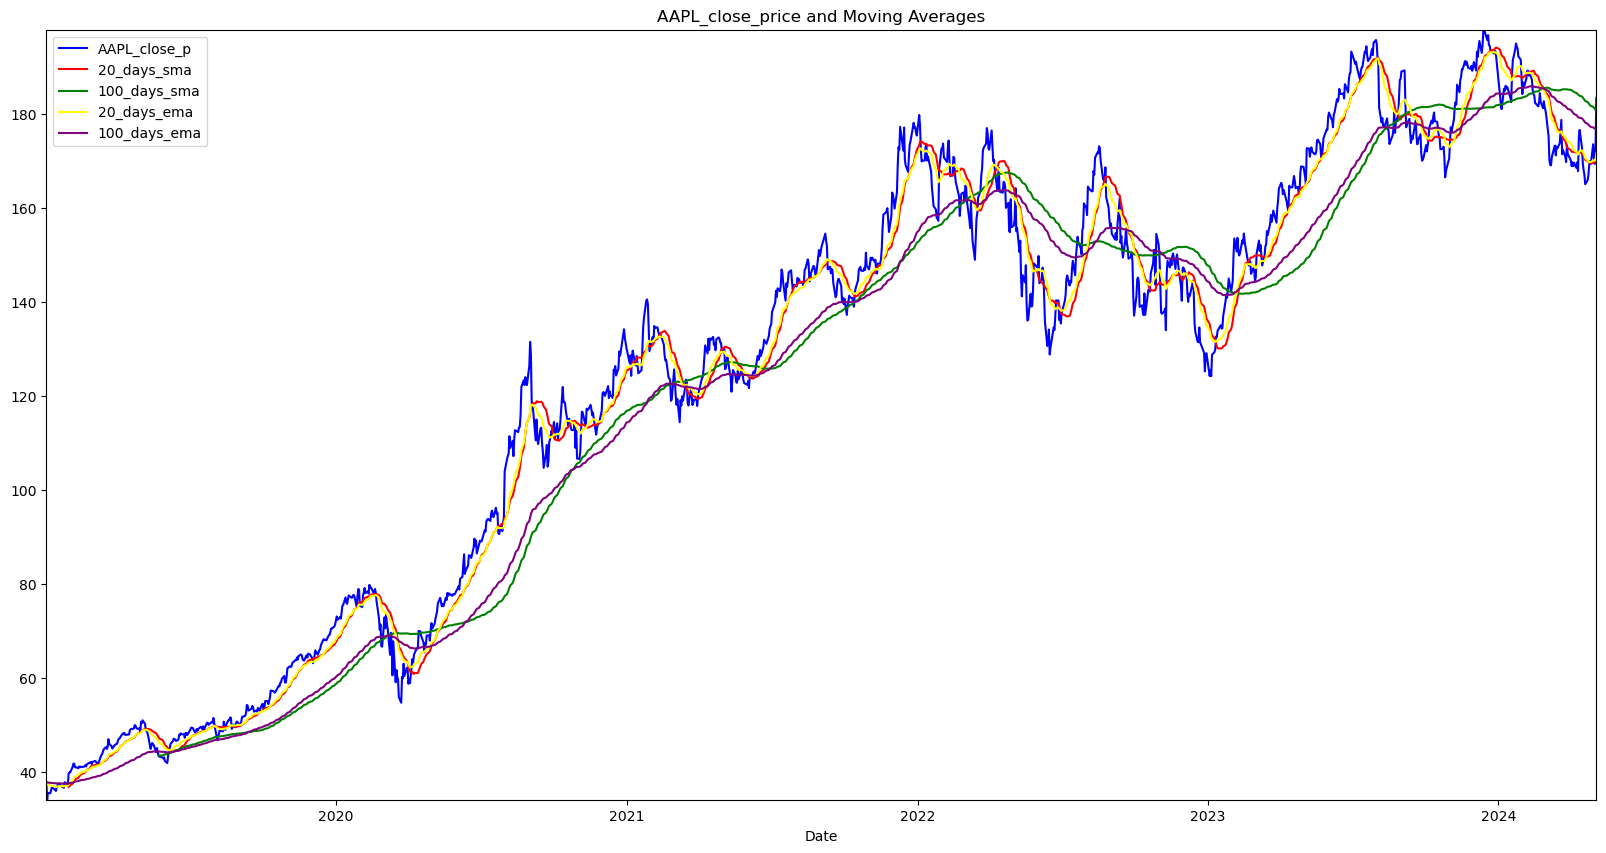

In [77]:
close_data = df['Close']
sma_close_short = close_data.rolling(window=20).mean()
sma_close_long = close_data.rolling(window=100).mean()
ema_close_short = close_data.ewm(span=20, adjust=False).mean()
ema_close_long = close_data.ewm(span=100, adjust=False).mean()



# 可视化
plt.figure(figsize=(20,10))
plt.plot(close_data.index, close_data, label='AAPL_close_p', color='blue')
plt.plot(sma_close_short.index, sma_close_short, label='20_days_sma', color='red')
plt.plot(sma_close_long.index, sma_close_long, label='100_days_sma', color='green')
plt.plot(ema_close_short.index, ema_close_short, label='20_days_ema', color='yellow')
plt.plot(ema_close_long.index, ema_close_long, label='100_days_ema', color='purple')
plt.xlabel('Date')
plt.autoscale(tight=True)
plt.title('AAPL_close_price and Moving Averages')
plt.legend()
# plt.show()

## 使用趋势线结合模型进行预测

In [78]:
# 使用简单的logistic回归模型
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


target = (close_data.shift(-1) > close_data).astype(int)

features = pd.DataFrame(
    {
        'close': close_data,
        'sma_short': sma_close_short,
        'sma_long': sma_close_long,
    }
).dropna()
# print(features)

# 分离标签
target = target.reindex(features.index)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# 训练模型
model = LogisticRegression()
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.5140562248995983


## 使用SVR-tuned进行预测

[[-1.84122878]
 [-1.92081097]
 [-1.89010131]
 ...
 [ 0.79865167]
 [ 0.81755126]
 [ 0.76232303]]


e:\applist\miniconda\envs\sklearn\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                Actual  Prediction
Date                              
2023-04-11  159.250000  159.979578
2023-04-12  164.680984  159.284278
2023-04-13  164.332855  164.707791
2023-04-14  164.352737  164.360140
2023-04-17  165.586166  164.379995
...                ...         ...
2024-04-29  170.330002  173.514673
2024-04-30  169.300003  170.349036
2024-05-01  173.029999  169.320455
2024-05-02  183.380005  173.045319
2024-05-03  125.060111  183.381086

[269 rows x 2 columns]
SVR RMSE:  4.237437022248458
SVR R2 score:  0.8079829365162687


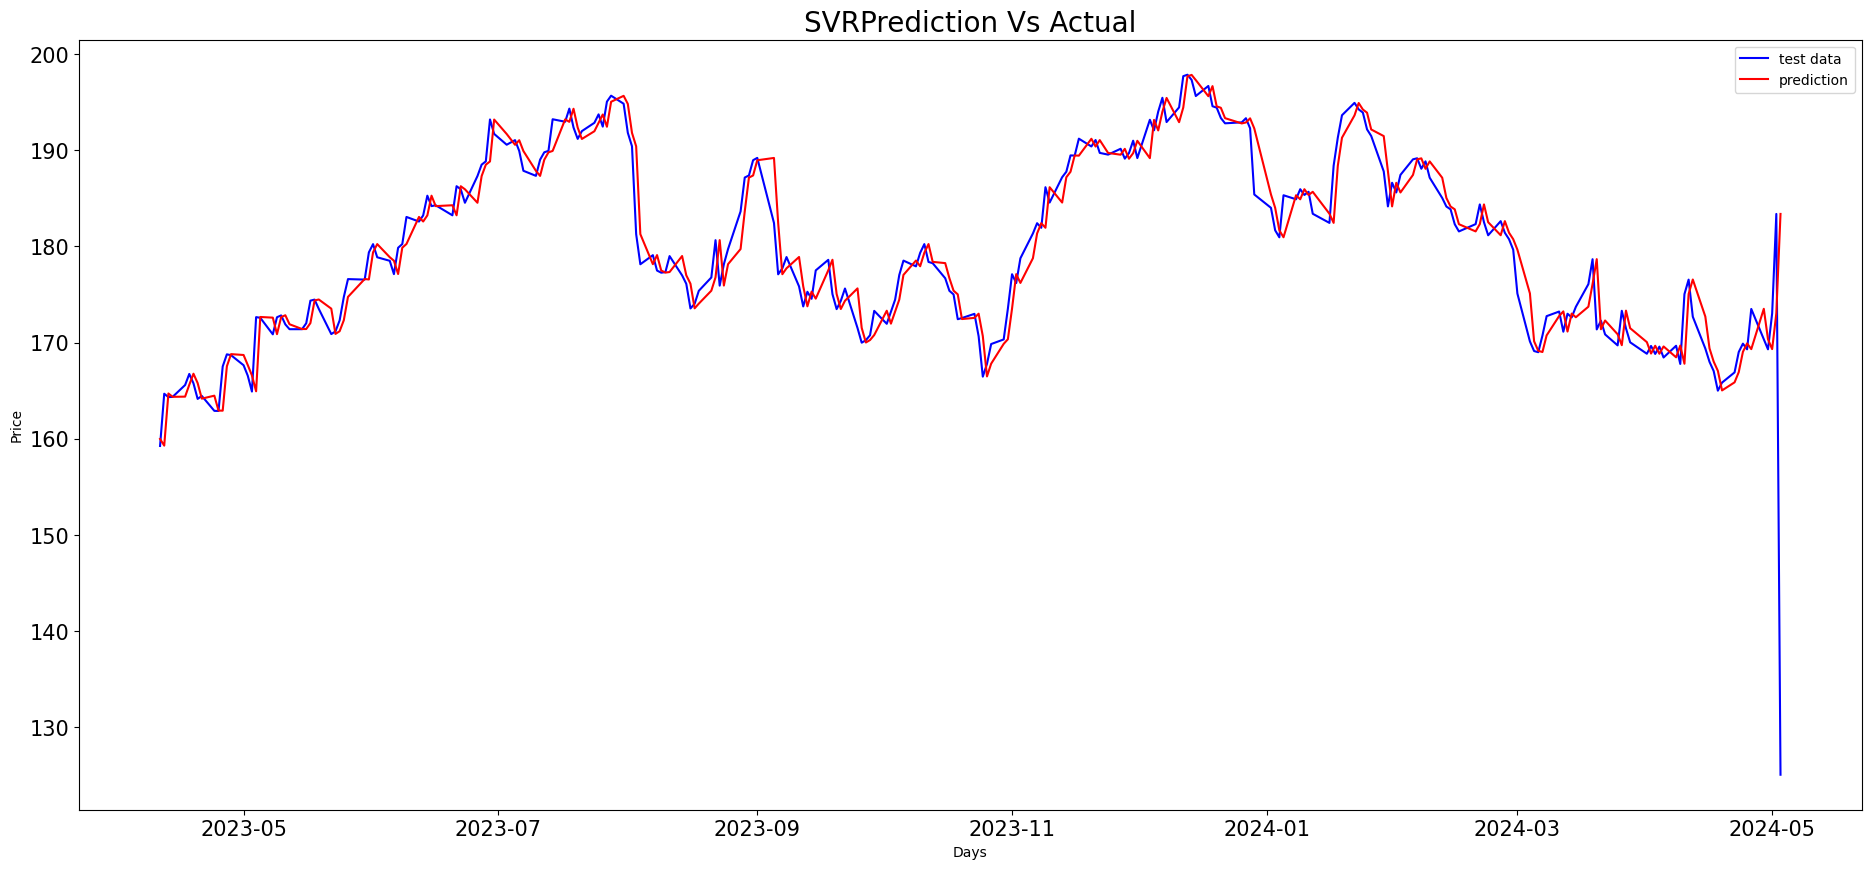

In [79]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score



def model_SVR(x_train, y_train, validation_x):
    svr_model = SVR(kernel='linear')
    model = svr_model.fit(x_train, y_train)
    return model


# 使用SVM-TUNED模型
def model_SVRTuning(x_train, y_train, validation_x):
    hyperparameters_linearSVR = {
        'C':[0.5, 1.0, 10.0, 50.0, 100.0, 120.0,150.0, 300.0, 500.0,700.0,800.0, 1000.0],
        'epsilon':[0, 0.1, 0.5, 0.7, 0.9],
    }
    
    grid_search_SVR_feat = GridSearchCV(estimator=model_SVR(x_train, y_train, validation_x),
                           param_grid=hyperparameters_linearSVR,
                           cv=TimeSeriesSplit(n_splits=10),
    )

    model = grid_search_SVR_feat.fit(x_train, y_train)
    print('Best Parameters for SVR:', model.best_params_)
    
    return model


# 进行模型评估
def bestModel_validateResult(model, model_name, x_test,y_test):
    prediction = model.predict(x_test)
    prediction = pd.DataFrame(prediction, index=y_test.index)
    prediction_df = pd.concat([y_test, prediction], axis=1)
    prediction_df.columns = ['Actual', 'Prediction']
    print(prediction_df)
    RMSE_Score = np.sqrt(mean_squared_error(y_test, prediction))
    R2_Score = r2_score(y_test, prediction)
    plt.figure(figsize = (23,10))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(model_name + 'Prediction Vs Actual',fontsize = 20)
    plt.plot(y_test, label='test data',color = 'blue')
    plt.plot(prediction, label='prediction', color = 'red')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score) 
    return RMSE_Score, R2_Score


# 进行数据归一化
from sklearn.preprocessing import StandardScaler

target_data = close_data.shift(-1).fillna(value=close_data.mean())
def normalize_split_data(data,target_data):
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    X_train, X_test, y_train, y_test = train_test_split(data, target_data, test_size=0.2, shuffle=False)
    return X_train, X_test, y_train, y_test

x_train, x_test, y_train, y_test = normalize_split_data(close_data.to_frame(), target_data.to_frame())

print(x_train)


# 使用SVM-TUNED模型
# svr_model = model_SVRTuning(x_train, y_train, x_test)
svr_model = SVR(kernel='linear', C=1000.0, epsilon=0)
svr_model.fit(x_train, y_train)
RMSE_Score, R2_Score = bestModel_validateResult(svr_model, 'SVR', x_test, y_test)




                   0
Date                
2024-03-22  0.513326
2024-03-25  0.103698
2024-03-26 -0.222860
2024-03-27  0.808374
2024-03-28  0.284162
2024-04-01 -0.131196
2024-04-02 -0.472078
2024-04-03 -0.240051
2024-04-04 -0.477804
2024-04-05 -0.260100
2024-04-08 -0.583795
2024-04-09 -0.234320
2024-04-10 -0.775719
2024-04-11  1.303938
2024-04-12  1.736487
2024-04-15  0.630773
2024-04-16 -0.317390
2024-04-17 -0.712699
2024-04-18 -0.987697
2024-04-19 -1.572062
2024-04-22 -1.331441
2024-04-23 -1.027800
2024-04-24 -0.420514
2024-04-25 -0.171300
2024-04-26 -0.340307
2024-04-29  0.862801
2024-04-30 -0.045259
2024-05-01 -0.340307
2024-05-02  0.728167
2024-05-03  3.692971
predicted price: [149.42312531 130.04663145 114.5995655  163.37967583 138.58303187
 118.93547882 102.81086826 113.78638791 102.54001582 112.83799087
  97.52635113 114.05744711  88.44783232 186.82123058 207.28196121
 154.97870163 110.1280192   91.42886319  78.42070971  50.77866786
  62.16067293  76.52370886 105.24998749 117.038

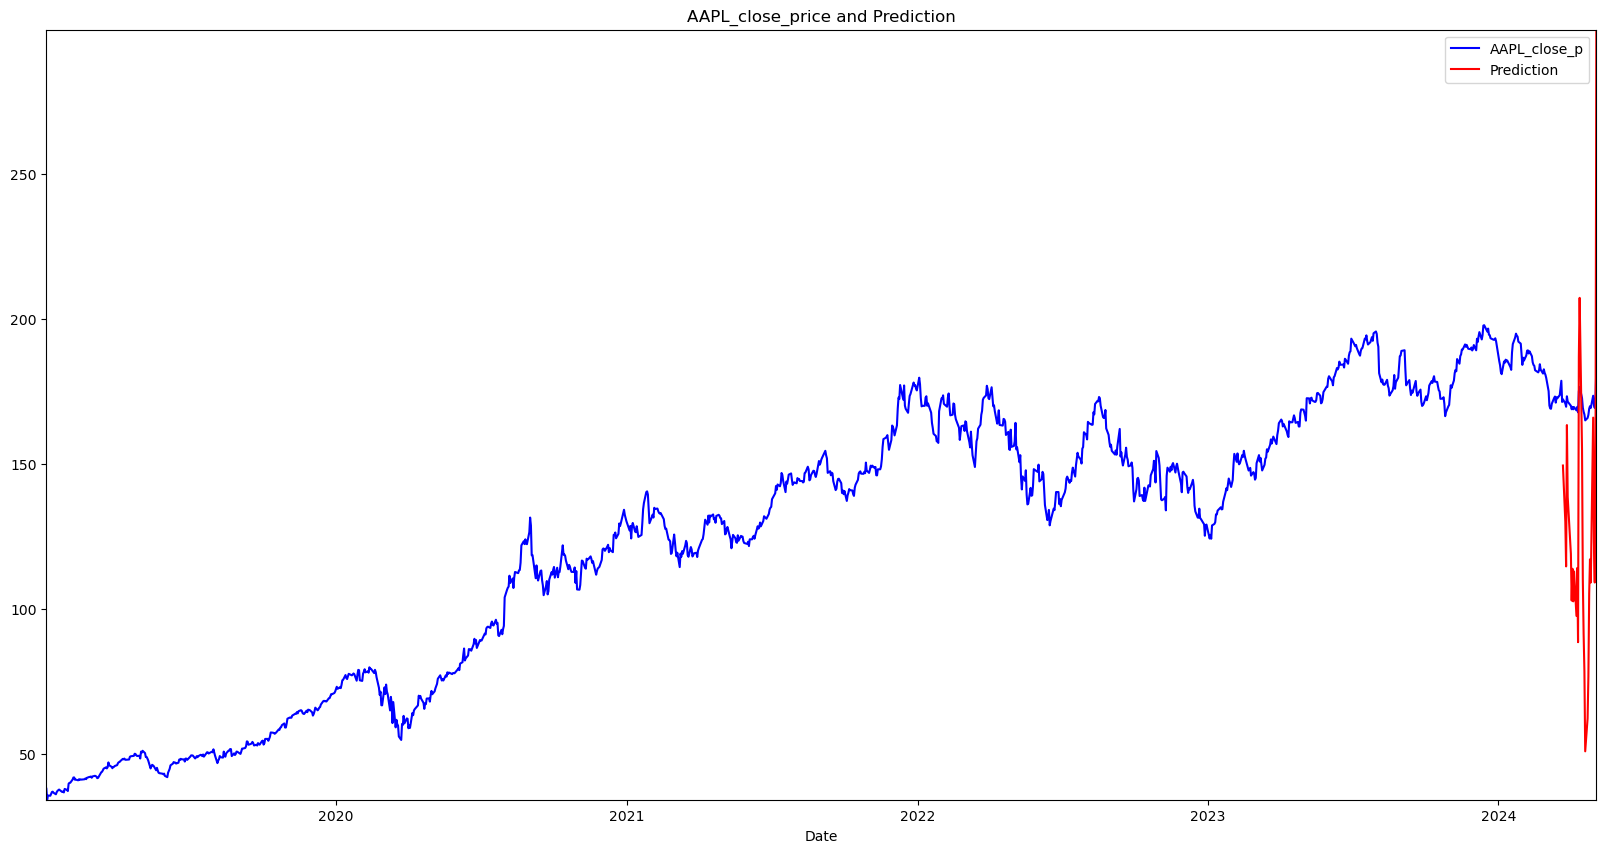

In [80]:
# 预测未来一个月的股票趋势
def predict_future_trend(origin_data, data, model):
    prediction = model.predict(data)
    print(f"predicted price: {prediction}")
    
    # 可视化
    plt.figure(figsize=(20,10))
    plt.plot(origin_data.index, origin_data, label='AAPL_close_p', color='blue')
    plt.plot(data.index, prediction, label='Prediction', color='red')
    plt.xlabel('Date')
    plt.autoscale(tight=True)
    plt.title('AAPL_close_price and Prediction')
    plt.legend()
    plt.show()
    
    
input_data = close_data[-30:].to_frame()
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(input_data, index=close_data[-30:].index)
print(input_data)
predict_future_trend(close_data, input_data, svr_model)
